In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Once the repo is cloned then:
#best practice remove and reeinstal fspec
#!rm -rf /opt/conda/lib/python3.10/site-packages/fsspec*
#!pip install fsspec==2024.6.1 --force-reinstall --no-deps

#pip install e .
#pip install -e ".[demo]"


# #install also to vizualize figures
# sudo apt-get update
# sudo apt-get install -y libgl1-mesa-glx
# sudo apt-get install -y libglib2.0-0



In [2]:
!pip install shapely

In [3]:
!pip install s3fs

In [4]:
!pip install rasterio

## Running an example of general segmentation using SAM2

In this example, the model segments everything it finds in the image.


In [5]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [7]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

### Geting the image from Solafune competition uploaded to my s3 bucket

In [8]:
import rasterio
import numpy as np

def load_image_as_array(image_s3_uri):
    """Load an image from S3 and convert it to a NumPy array."""
    # Open the image using rasterio
    with rasterio.open(image_s3_uri) as src:
        # Read the image data
        image = src.read()  # This will read all the bands
        image = np.moveaxis(image, 0, -1)  # Move channels to the last dimension
        image = image[:, :, :3]  # Assuming you want to use only the first 3 bands (R, G, B)
    return image

# Example usage
image_s3_uri = 's3://solafune/train_images/images/train_25.tif'
image = load_image_as_array(image_s3_uri)

# Now 'image' is a NumPy array in RGB format
print(image.shape)  # This will print the shape of the image array


# Assuming 'image' is the array you loaded
image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
image_normalized = image_normalized.astype(np.uint8)  # Convert to uint8

image = image_normalized

(802, 1198, 3)


In [9]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "./segment-anything-2/checkpoints/sam2_hiera_large.pt" # try large sam2_hiera_large.pt
model_cfg = "sam2_hiera_l.yaml" #"sam2_hiera_l.yaml" for large

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [10]:
masks = mask_generator.generate(image)

In [11]:
print(len(masks))
print(masks[0].keys())

101
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


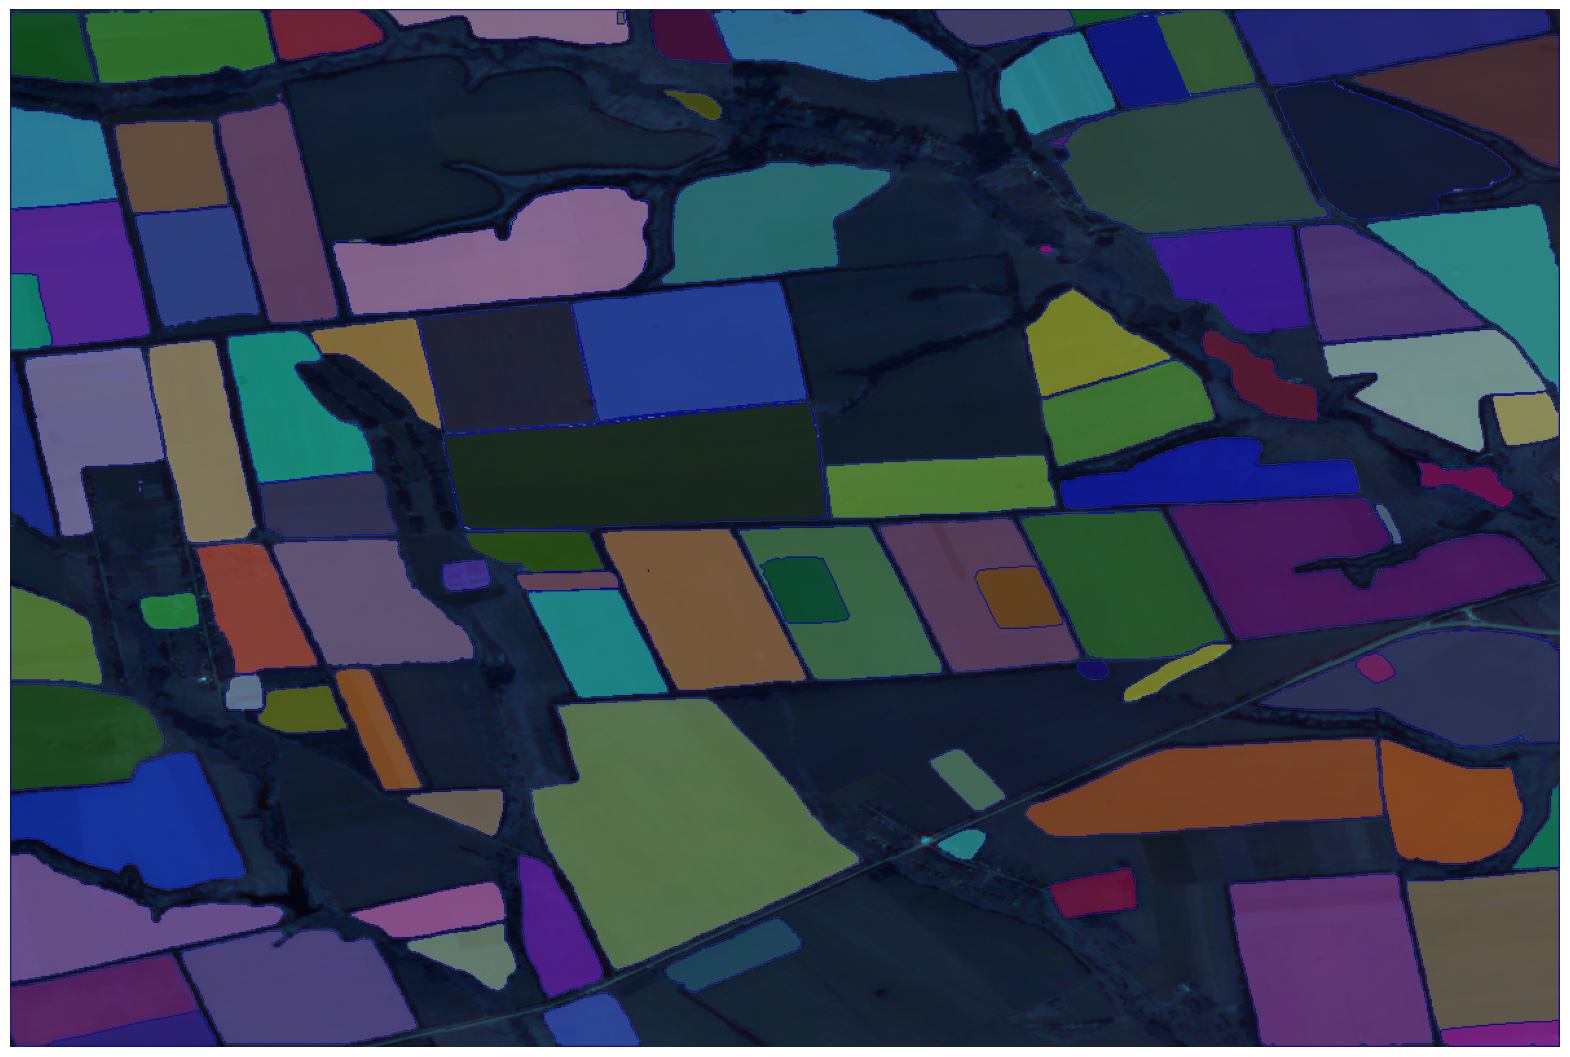

In [12]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

# Finetuning by retraining the model with solafune's data

In [13]:
import numpy as np
import rasterio
from shapely.geometry import Polygon
from shapely.ops import transform
import cv2
from PIL import Image, ImageDraw

def polygon_to_mask(polygon, width, height):
    mask = Image.new('L', (width, height), 0)
    ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
    return torch.tensor(np.array(mask), dtype=torch.float32)


In [14]:
def load_image(image_s3_uri):
    """Load an image from S3 and convert it to a NumPy array."""
    # Open the image using rasterio
    with rasterio.open(image_s3_uri) as src:
        # Read the image data
        image = src.read()  # This will read all the bands
        image = np.moveaxis(image, 0, -1)  # Move channels to the last dimension
        image = image[:, :, :3]  # Assuming you want to use only the first 3 bands (R, G, B)
        image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
        image_normalized = image_normalized.astype(np.uint8)
    return image_normalized


def load_annotations(annotation_s3_uri, image_filename):
    """Load annotations for a specific image from a JSON file on S3."""
    fs = s3fs.S3FileSystem()
    with fs.open(annotation_s3_uri, 'r') as f:
        data = json.load(f)
    
    for img in data['images']:
        if img['file_name'] == image_filename:
            return img['annotations']
    return None
    
def load_original_annotations(annotation_s3_uri):
    """Load annotations for a specific image from a JSON file on S3."""
    fs = s3fs.S3FileSystem()
    with fs.open(annotation_s3_uri, 'r') as f:
        data = json.load(f)
    return data

In [15]:
import torch
from torch.utils.data import Dataset

class SAM2Dataset(Dataset):
    def __init__(self, image_filenames, annotations, image_s3_prefix):
        self.image_filenames = image_filenames
        self.annotations = annotations
        self.image_s3_prefix = image_s3_prefix

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        image_s3_uri = os.path.join(self.image_s3_prefix, image_filename)

        # Load image using the new load_image function
        image = load_image(image_s3_uri)
        
        # Ensure the image is in the correct format for the model
        image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        
        # Set requires_grad=True to enable gradient computation
        #image_tensor.requires_grad_(True)

        # Load annotations
        annotations = load_annotations(self.annotations, image_filename)
        masks = []
        height, width = image.shape[:2]  # Get the image dimensions
        for annotation in annotations:
            mask = polygon_to_mask(annotation['segmentation'], width, height)
            masks.append(mask)

        # Stack all masks into a single tensor
        masks_tensor = torch.stack(masks, dim=0)

        return image_tensor, masks_tensor


In [21]:
# Load Json
import s3fs
import json
train_annotation_s3_uri = 's3://solafune/train_annotation.json'

In [22]:
from torch.utils.data import DataLoader

# List of image filenames
image_filenames = [img['file_name'] for img in load_original_annotations(train_annotation_s3_uri)['images']]

#image_filenames = ['train_28.tif'] # set a quick training with specific images
image_s3_prefix = 's3://solafune/train_images/images'

# Instantiate Dataset
dataset = SAM2Dataset(image_filenames, train_annotation_s3_uri, image_s3_prefix)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [23]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

model = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)


In [24]:
def convert_to_binary_masks(predicted_masks):
    """
    Converts boolean masks from SAM2's output to binary masks.

    Args:
    - predicted_masks (list of dict): List of predicted masks with 'segmentation' key containing boolean arrays.

    Returns:
    - binary_masks (list of np.array): List of binary masks (1 and 0).
    """
    binary_masks = []
    for mask_data in predicted_masks:
        # Convert the boolean segmentation mask to an integer binary mask
        binary_mask = mask_data['segmentation'].astype(np.uint8)
        binary_masks.append(binary_mask)
    
    return binary_masks

Batch 1:
 - Image shape before permute: torch.Size([1, 3, 802, 1167])
 - Masks shape: torch.Size([1, 1244, 802, 1167])
 - Image shape after permute: torch.Size([802, 1167, 3])


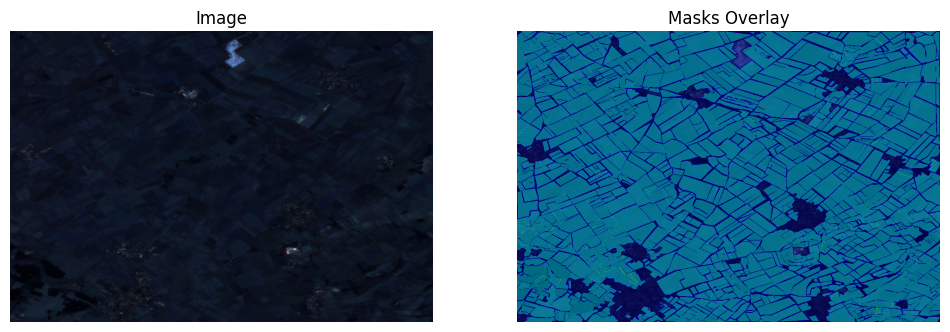

In [25]:
import s3fs
import json

#Looking into the data - Checking if everything is in good order #  image and gt masks


for i, (images, masks) in enumerate(data_loader):
    print(f"Batch {i + 1}:")
    print(f" - Image shape before permute: {images.shape}")
    print(f" - Masks shape: {masks.shape}")
    
    # Assuming images are in the shape [B, C, H, W]
    # Permute to shape [H, W, C] for visualization
    image = images[0].permute(1, 2, 0)
    print(f" - Image shape after permute: {image.shape}")
    
    plt.figure(figsize=(12, 6))
    
    # Show the image
    plt.subplot(1, 2, 1)
    plt.imshow(image.detach().numpy())
    plt.title("Image")
    plt.axis('off')
    
    # Show the masks overlayed on the image
    combined_mask = masks[0].sum(axis=0)
    plt.subplot(1, 2, 2)
    plt.imshow(image.detach().numpy())
    plt.imshow(combined_mask, alpha=0.5, cmap='jet')
    plt.title("Masks Overlay")
    plt.axis('off')
    
    plt.show()
    
    # Break after the first batch to inspect
    if i == 0:
        break


# Main train Loop

##### Using a panoptic loss both to better perform on the chalange, and also to compare multiple masks.

In [39]:
import torch
import torch.nn as nn
from tqdm import tqdm

class PanopticLoss(nn.Module):
    def __init__(self, iou_threshold=0.5):
        super(PanopticLoss, self).__init__()
        self.iou_threshold = iou_threshold

    def forward(self, predicted_masks, target_masks):
        # Convert to boolean tensors for logical operations
        predicted_masks = predicted_masks > 0.5
        target_masks = target_masks > 0.5

        print(f"Predicted Masks Shape: {predicted_masks.shape}")
        print(f"Target Masks Shape: {target_masks.shape}")

        batch_size = predicted_masks.shape[0]
        total_loss = 0.0

        for i in range(batch_size):
            pred = predicted_masks[i]
            target = target_masks[i]

            print(f"Batch {i + 1}: Pred Shape: {pred.shape}, Target Shape: {target.shape}")

            matched_pred, matched_target = self.match_masks(pred, target)

            print(f"Matched Pred Shape: {matched_pred.shape}, Matched Target Shape: {matched_target.shape}")

            iou_scores = self.calculate_iou(matched_pred, matched_target)

            print(f"IoU Scores: {iou_scores}")

            if iou_scores.numel() > 0:  # Ensure there's something to calculate
                loss = 1 - iou_scores.mean()
                print(f"Loss for Batch {i + 1}: {loss.item()}")
            else:
                loss = torch.tensor(0.0, device=pred.device)
                print("No valid IoU scores, setting loss to 0.")

            total_loss += loss

        final_loss = total_loss / batch_size
        print(f"Final Loss: {final_loss.item()}")

        return final_loss

    def match_masks(self, pred, target):
        pred = pred.view(pred.size(0), -1)
        target = target.view(target.size(0), -1)

        print(f"Flattened Pred Shape: {pred.shape}")
        print(f"Flattened Target Shape: {target.shape}")

        matched_pred = []
        matched_target = []

        for i, t in enumerate(target):
            best_iou = 0
            best_pred = None
            for j, p in enumerate(pred):
                intersection = torch.logical_and(p, t).float().sum()
                union = torch.logical_or(p, t).float().sum()
                iou = (intersection + 1e-6) / (union + 1e-6)
                if iou > best_iou:
                    best_iou = iou
                    best_pred = p
            if best_iou > self.iou_threshold:
                matched_pred.append(best_pred)
                matched_target.append(t)

        if matched_pred and matched_target:
            print(f"Number of Matched Pairs: {len(matched_pred)}")
            return torch.stack(matched_pred), torch.stack(matched_target)
        else:
            print("No matches found. Returning zero-filled tensors.")
            return torch.zeros_like(pred), torch.zeros_like(target)

    def calculate_iou(self, pred, target):
        if pred.dim() == 2:
            pred = pred.unsqueeze(0)
        if target.dim() == 2:
            target = target.unsqueeze(0)

        intersection = (pred & target).float().sum((1, 2))
        union = (pred | target).float().sum((1, 2))
        iou = (intersection + 1e-6) / (union + 1e-6)
        return iou


In [40]:
# import torch

# class SAM2MaskGenerationFunction(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, img_tensor, mask_generator):
#         # Save the original image tensor for backward pass
#         ctx.save_for_backward(img_tensor)
        
#         # Convert the image tensor to a NumPy array for SAM2
#         img_np = img_tensor.permute(1, 2, 0).cpu().numpy()

#         # Generate masks using SAM2 (non-differentiable operation)
#         masks_output = mask_generator.generate(img_np)

#         # Convert masks to binary mask tensor
#         binary_masks_np = np.array(convert_to_binary_masks(masks_output))
#         binary_masks_tensor = torch.tensor(binary_masks_np, dtype=torch.float32).to(img_tensor.device)
        
#         # Reintroduce a differentiable operation
#         #binary_masks_tensor = binary_masks_tensor * img_tensor.sum() * 0 + binary_masks_tensor

#         return binary_masks_tensor

#     @staticmethod
#     def backward(ctx, grad_output):
#         # Retrieve the saved image tensor
#         img_tensor, = ctx.saved_tensors

#         # Here, sum/average the gradients to reduce the dimensions
#         # For simplicity, we assume reducing across the first dimension (e.g., channels or masks)
#         grad_input = grad_output.sum(dim=0, keepdim=True)  # Adjust this based on how you want to reduce

#         # Optionally, expand/reduce dimensions to match input tensor
#         grad_input = grad_input.expand_as(img_tensor)

#         return grad_input, None  # Return gradients for img_tensor and None for mask_generator

# # Example usage remains the same as before.


In [58]:
import torch
import torch.nn as nn

class SimpleBCELoss(nn.Module):
    def __init__(self):
        super(SimpleBCELoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, predicted_masks, target_masks):
        # Check initial grad_fn
        print("Initial predicted_masks grad_fn:", predicted_masks.grad_fn)
        print("Initial target_masks grad_fn:", target_masks.grad_fn)

        # Collapse masks by summing across the mask dimension (dim=1)
        predicted_mask_sum = predicted_masks.sum(dim=1)
        target_mask_sum = target_masks.sum(dim=1)

        # Flatten the masks to make them suitable for binary cross-entropy loss
        predicted_mask_flat = predicted_mask_sum.view(predicted_mask_sum.size(0), -1)
        target_mask_flat = (target_mask_sum > 0).float().view(target_mask_sum.size(0), -1)

        # Calculate binary cross-entropy loss with logits
        loss = self.bce_loss(predicted_mask_flat, target_mask_flat)

        # Check if loss has a valid grad_fn
        print("Loss grad_fn:", loss.grad_fn)

        return loss


In [59]:
def train_model_with_feedback(model, data_loader, mask_generator, num_epochs=5, print_interval=1):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    #criterion = PanopticLoss(iou_threshold=0.5)  # Make sure this is fully differentiable
    criterion = SimpleBCELoss()  # Make sure this is fully differentiableSimplifiedPanopticLoss
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (images, masks) in enumerate(tqdm(data_loader, total=len(data_loader))):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            # Generate predicted masks
            masks_pred = []
            for img in images:
                img = img.permute(1, 2, 0).cpu().numpy()
                masks_output = mask_generator.generate(img)
                binary_masks_np = np.array(convert_to_binary_masks(masks_output))
                masks_pred.append(torch.tensor(binary_masks_np, dtype=torch.float32,requires_grad=True).to(device))

            masks_pred = torch.stack(masks_pred)
            
            # Check if masks_pred still has a valid grad_fn
            #print("Before loss calculation:", masks_pred.grad_fn)
            #loss = masks_pred.sum()  # Simplified loss for debugging
            # Compute the loss (simplify this part to isolate the problem)
            loss = criterion(masks_pred, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Print loss for every `print_interval` batches
            if (i + 1) % print_interval == 0:
                print(f"Batch [{i + 1}/{len(data_loader)}], Loss: {loss.item():.4f}")

        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {epoch_loss / len(data_loader):.4f}")

    print("Training completed.")




In [ ]:
# Replace with your actual data loader, model, and mask_generator
train_model_with_feedback(model, data_loader, mask_generator, num_epochs=5, print_interval=1)

  2%|▏         | 1/50 [00:04<03:40,  4.49s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fd9ba0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fda0b0>
Batch [1/50], Loss: 0.3005


  4%|▍         | 2/50 [00:10<04:15,  5.33s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fda0b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fda0b0>
Batch [2/50], Loss: 0.4665


  6%|▌         | 3/50 [00:17<04:50,  6.18s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fda0b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fd9ba0>
Batch [3/50], Loss: 0.6906
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fd9ba0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fda0b0>


  8%|▊         | 4/50 [00:22<04:24,  5.76s/it]

Batch [4/50], Loss: 0.3855
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8452282020>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d5240>


 10%|█         | 5/50 [00:28<04:22,  5.84s/it]

Batch [5/50], Loss: 0.5909
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8452782230>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8452782f20>


 12%|█▏        | 6/50 [00:34<04:12,  5.74s/it]

Batch [6/50], Loss: 0.7467
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8452782f20>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8581998460>


 14%|█▍        | 7/50 [00:39<03:55,  5.48s/it]

Batch [7/50], Loss: 0.4272
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845c3442b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c3478b0>


 16%|█▌        | 8/50 [00:43<03:39,  5.22s/it]

Batch [8/50], Loss: 0.8223


 18%|█▊        | 9/50 [00:48<03:23,  4.95s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845c3442b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c3478b0>
Batch [9/50], Loss: 0.6901


 20%|██        | 10/50 [00:53<03:27,  5.19s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85819982b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c3478b0>
Batch [10/50], Loss: 0.3686


 22%|██▏       | 11/50 [00:58<03:13,  4.97s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c3478b0>
Batch [11/50], Loss: 0.4750
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8581998460>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8452731b70>


 24%|██▍       | 12/50 [01:03<03:05,  4.87s/it]

Batch [12/50], Loss: 0.4444
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6a10c0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84527f0040>


 26%|██▌       | 13/50 [01:07<02:55,  4.73s/it]

Batch [13/50], Loss: 0.4369
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84522804f0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8452281f60>


 28%|██▊       | 14/50 [01:12<02:53,  4.81s/it]

Batch [14/50], Loss: 0.6452


 30%|███       | 15/50 [01:19<03:06,  5.33s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6a9690>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fda0b0>
Batch [15/50], Loss: 0.6049
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85819841f0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85819853c0>


 32%|███▏      | 16/50 [01:24<03:02,  5.36s/it]

Batch [16/50], Loss: 0.4850
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85819853c0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85819853c0>


 34%|███▍      | 17/50 [01:30<02:59,  5.44s/it]

Batch [17/50], Loss: 0.8073


/tmp/ipykernel_11552/3612361884.py:10: RuntimeWarning: invalid value encountered in cast
  image_normalized = image_normalized.astype(np.uint8)
 36%|███▌      | 18/50 [01:34<02:42,  5.08s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84527f0040>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6a10c0>
Batch [18/50], Loss: 0.7080


 38%|███▊      | 19/50 [01:38<02:26,  4.72s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84527f0040>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6a10c0>
Batch [19/50], Loss: 0.6491


 40%|████      | 20/50 [01:46<02:54,  5.83s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6a10c0>
Batch [20/50], Loss: 0.7368
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6a10c0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d5240>


 42%|████▏     | 21/50 [01:52<02:51,  5.93s/it]

Batch [21/50], Loss: 0.6359


 44%|████▍     | 22/50 [01:57<02:35,  5.56s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6a10c0>
Batch [22/50], Loss: 0.6819
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6a10c0>


 46%|████▌     | 23/50 [02:02<02:29,  5.54s/it]

Batch [23/50], Loss: 0.4806
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8452282020>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca00>


 48%|████▊     | 24/50 [02:07<02:17,  5.30s/it]

Batch [24/50], Loss: 0.3575
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d5240>


 50%|█████     | 25/50 [02:12<02:09,  5.19s/it]

Batch [25/50], Loss: 0.5667


 52%|█████▏    | 26/50 [02:16<01:57,  4.89s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d67ad40>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d679ed0>
Batch [26/50], Loss: 0.3162


 54%|█████▍    | 27/50 [02:21<01:51,  4.85s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84527f0040>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84527f0040>
Batch [27/50], Loss: 0.6987


 56%|█████▌    | 28/50 [02:25<01:43,  4.72s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84527f0040>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8452782f20>
Batch [28/50], Loss: 0.5607
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84527f0040>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8452782f20>


 58%|█████▊    | 29/50 [02:30<01:39,  4.73s/it]

Batch [29/50], Loss: 0.5846


 60%|██████    | 30/50 [02:37<01:47,  5.35s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6a10c0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f858196eaa0>
Batch [30/50], Loss: 0.4854


 62%|██████▏   | 31/50 [02:43<01:45,  5.53s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845c3478b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c345e70>
Batch [31/50], Loss: 0.4886


 64%|██████▍   | 32/50 [02:47<01:33,  5.20s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c3478b0>
Batch [32/50], Loss: 0.5538


 66%|██████▌   | 33/50 [02:52<01:24,  4.94s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c3478b0>
Batch [33/50], Loss: 0.4002
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8452280400>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84527f0040>


 68%|██████▊   | 34/50 [02:56<01:16,  4.76s/it]

Batch [34/50], Loss: 0.4727


 70%|███████   | 35/50 [03:03<01:21,  5.44s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84527f0040>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6a10c0>
Batch [35/50], Loss: 0.5850


 72%|███████▏  | 36/50 [03:09<01:16,  5.46s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d5240>
Batch [36/50], Loss: 0.7032
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d5240>


 74%|███████▍  | 37/50 [03:15<01:14,  5.75s/it]

Batch [37/50], Loss: 0.7455
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c3478b0>


 76%|███████▌  | 38/50 [03:20<01:04,  5.41s/it]

Batch [38/50], Loss: 0.4614
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca00>


 78%|███████▊  | 39/50 [03:25<00:58,  5.33s/it]

Batch [39/50], Loss: 0.4239
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6a10c0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d5240>


 80%|████████  | 40/50 [03:30<00:53,  5.37s/it]

Batch [40/50], Loss: 1.1830
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84527f0040>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c3442b0>


 82%|████████▏ | 41/50 [03:36<00:50,  5.59s/it]

Batch [41/50], Loss: 0.7346
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6a10c0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8452282020>


 84%|████████▍ | 42/50 [03:42<00:45,  5.72s/it]

Batch [42/50], Loss: 0.7226
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6a10c0>


 86%|████████▌ | 43/50 [03:48<00:38,  5.56s/it]

Batch [43/50], Loss: 0.6514
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6a10c0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca00>


 88%|████████▊ | 44/50 [03:54<00:35,  5.88s/it]

Batch [44/50], Loss: 0.6663
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6a10c0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8452281f60>


 90%|█████████ | 45/50 [03:59<00:28,  5.68s/it]

Batch [45/50], Loss: 0.6424


 92%|█████████▏| 46/50 [04:04<00:20,  5.24s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8452281f60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6a10c0>
Batch [46/50], Loss: 0.7298


 94%|█████████▍| 47/50 [04:08<00:14,  4.93s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d63e0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6a10c0>
Batch [47/50], Loss: 0.6849


 96%|█████████▌| 48/50 [04:13<00:09,  4.96s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6a9690>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6a10c0>
Batch [48/50], Loss: 0.6940
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84527f0040>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6a10c0>


 98%|█████████▊| 49/50 [04:18<00:04,  4.94s/it]

Batch [49/50], Loss: 0.5515
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845c3442b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c3442b0>


100%|██████████| 50/50 [04:24<00:00,  5.28s/it]


Batch [50/50], Loss: 1.1038
Epoch [1/5], Average Loss: 0.6010


  2%|▏         | 1/50 [00:04<03:42,  4.54s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fda6b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fda0b0>
Batch [1/50], Loss: 0.6987
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fda6b0>


  4%|▍         | 2/50 [00:09<04:03,  5.07s/it]

Batch [2/50], Loss: 0.4806


  6%|▌         | 3/50 [00:14<03:51,  4.92s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6a10c0>
Batch [3/50], Loss: 0.8223


  8%|▊         | 4/50 [00:21<04:26,  5.80s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d67a9e0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f864c0bdc60>
Batch [4/50], Loss: 0.6906


 10%|█         | 5/50 [00:29<04:47,  6.39s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6a10c0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c4d90>
Batch [5/50], Loss: 0.5850
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8624142da0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fda0b0>


 12%|█▏        | 6/50 [00:36<04:45,  6.50s/it]

Batch [6/50], Loss: 0.7455
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6a10c0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8452280400>


 14%|█▍        | 7/50 [00:40<04:10,  5.84s/it]

Batch [7/50], Loss: 0.3005
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6c4d90>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8624142da0>


 16%|█▌        | 8/50 [00:45<03:48,  5.43s/it]

Batch [8/50], Loss: 0.3855
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d679ed0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d63e0>


 18%|█▊        | 9/50 [00:51<03:52,  5.67s/it]

Batch [9/50], Loss: 0.5909
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f858196eaa0>


 20%|██        | 10/50 [00:57<03:48,  5.71s/it]

Batch [10/50], Loss: 0.8073


 22%|██▏       | 11/50 [01:01<03:23,  5.21s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d63e0>
Batch [11/50], Loss: 0.7080


 24%|██▍       | 12/50 [01:06<03:19,  5.24s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d63e0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d5240>
Batch [12/50], Loss: 1.1830


 26%|██▌       | 13/50 [01:11<03:08,  5.09s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d67a9e0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d679ed0>
Batch [13/50], Loss: 0.6940
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85819982b0>


 28%|██▊       | 14/50 [01:16<03:06,  5.18s/it]

Batch [14/50], Loss: 0.4850
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8581998460>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8452280400>


 30%|███       | 15/50 [01:22<03:09,  5.42s/it]

Batch [15/50], Loss: 0.7226
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8452281f60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c4588b0>


 32%|███▏      | 16/50 [01:26<02:51,  5.03s/it]

Batch [16/50], Loss: 0.4614
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d63e0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84522804f0>


 34%|███▍      | 17/50 [01:31<02:46,  5.03s/it]

Batch [17/50], Loss: 0.6452
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8452281f60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d67a9e0>


 36%|███▌      | 18/50 [01:35<02:30,  4.71s/it]

Batch [18/50], Loss: 0.4369
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6a10c0>


 38%|███▊      | 19/50 [01:40<02:27,  4.77s/it]

Batch [19/50], Loss: 0.5515
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6a10c0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d679ed0>


 40%|████      | 20/50 [01:45<02:24,  4.81s/it]

Batch [20/50], Loss: 0.6514


 42%|████▏     | 21/50 [01:50<02:23,  4.94s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d63e0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85819841f0>
Batch [21/50], Loss: 0.7032
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8581998460>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c4d90>


 44%|████▍     | 22/50 [01:55<02:20,  5.01s/it]

Batch [22/50], Loss: 0.4444
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8624142da0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca00>


 46%|████▌     | 23/50 [02:02<02:28,  5.49s/it]

Batch [23/50], Loss: 0.6049


 48%|████▊     | 24/50 [02:08<02:28,  5.70s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85819841f0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d67a9e0>
Batch [24/50], Loss: 1.1038


 50%|█████     | 25/50 [02:14<02:23,  5.74s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d67a9e0>
Batch [25/50], Loss: 0.3686
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8452280400>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d67a9e0>


 52%|█████▏    | 26/50 [02:19<02:09,  5.39s/it]

Batch [26/50], Loss: 0.3575
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d67a9e0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85819982b0>


 54%|█████▍    | 27/50 [02:25<02:12,  5.77s/it]

Batch [27/50], Loss: 0.6663


 56%|█████▌    | 28/50 [02:29<01:56,  5.30s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d67a9e0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85819982b0>
Batch [28/50], Loss: 0.7298
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85819982b0>


 58%|█████▊    | 29/50 [02:34<01:48,  5.15s/it]

Batch [29/50], Loss: 0.6424


 60%|██████    | 30/50 [02:39<01:38,  4.94s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8624142da0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d67a9e0>
Batch [30/50], Loss: 0.6849


 62%|██████▏   | 31/50 [02:43<01:31,  4.79s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d679ed0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d67a9e0>
Batch [31/50], Loss: 0.6819
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f864c0bdc60>


 64%|██████▍   | 32/50 [02:48<01:26,  4.80s/it]

Batch [32/50], Loss: 0.5667


 66%|██████▌   | 33/50 [02:52<01:17,  4.57s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca00>
Batch [33/50], Loss: 0.4750
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6c4d90>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d67a9e0>


 68%|██████▊   | 34/50 [02:57<01:14,  4.63s/it]

Batch [34/50], Loss: 0.5538
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85819982b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d63e0>


 70%|███████   | 35/50 [03:02<01:10,  4.73s/it]

Batch [35/50], Loss: 0.7467


 72%|███████▏  | 36/50 [03:08<01:10,  5.07s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fda0b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8624142da0>
Batch [36/50], Loss: 0.4886


 74%|███████▍  | 37/50 [03:15<01:15,  5.77s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d5240>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c4d90>
Batch [37/50], Loss: 0.4854


 76%|███████▌  | 38/50 [03:20<01:05,  5.43s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c4d90>
Batch [38/50], Loss: 0.6901


 78%|███████▊  | 39/50 [03:24<00:55,  5.07s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c4d90>
Batch [39/50], Loss: 0.6491


 80%|████████  | 40/50 [03:28<00:47,  4.80s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8624142da0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d5240>
Batch [40/50], Loss: 0.3162
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8624142da0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fda6b0>


 82%|████████▏ | 41/50 [03:32<00:41,  4.65s/it]

Batch [41/50], Loss: 0.4727


 84%|████████▍ | 42/50 [03:36<00:35,  4.47s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d5240>
Batch [42/50], Loss: 0.4002
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c4d90>


 86%|████████▌ | 43/50 [03:41<00:32,  4.63s/it]

Batch [43/50], Loss: 0.4272
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8624142da0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8581998460>


 88%|████████▊ | 44/50 [03:50<00:34,  5.79s/it]

Batch [44/50], Loss: 0.7368
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6a10c0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8dfc40>


 90%|█████████ | 45/50 [03:56<00:29,  5.81s/it]

Batch [45/50], Loss: 0.4239
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d67a9e0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85819841f0>


 92%|█████████▏| 46/50 [04:02<00:24,  6.03s/it]

Batch [46/50], Loss: 0.7346
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8624142da0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85819982b0>


 94%|█████████▍| 47/50 [04:08<00:18,  6.06s/it]

Batch [47/50], Loss: 0.4665


 96%|█████████▌| 48/50 [04:12<00:10,  5.46s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6a10c0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8624142da0>
Batch [48/50], Loss: 0.5607
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8624142da0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d558cd0>


 98%|█████████▊| 49/50 [04:18<00:05,  5.46s/it]

Batch [49/50], Loss: 0.6359
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85819841f0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d679ed0>


100%|██████████| 50/50 [04:23<00:00,  5.26s/it]


Batch [50/50], Loss: 0.5846
Epoch [2/5], Average Loss: 0.6010


  0%|          | 0/50 [00:00<?, ?it/s]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d679ed0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84522804f0>


  2%|▏         | 1/50 [00:04<03:57,  4.86s/it]

Batch [1/50], Loss: 0.4444
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8452280400>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fda6b0>


  4%|▍         | 2/50 [00:09<03:44,  4.68s/it]

Batch [2/50], Loss: 0.3855


  6%|▌         | 3/50 [00:13<03:30,  4.49s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f864c0bdc60>
Batch [3/50], Loss: 0.6849
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8452281f60>


  8%|▊         | 4/50 [00:18<03:30,  4.57s/it]

Batch [4/50], Loss: 0.5667


 10%|█         | 5/50 [00:25<04:02,  5.38s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8581998460>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f858196eaa0>
Batch [5/50], Loss: 0.6049


 12%|█▏        | 6/50 [00:29<03:43,  5.07s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d63e0>
Batch [6/50], Loss: 0.4614
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d63e0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d5240>


 14%|█▍        | 7/50 [00:35<03:54,  5.45s/it]

Batch [7/50], Loss: 0.6663


 16%|█▌        | 8/50 [00:41<03:48,  5.45s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d5240>
Batch [8/50], Loss: 1.1830
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d40d0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d5240>


 18%|█▊        | 9/50 [00:46<03:41,  5.41s/it]

Batch [9/50], Loss: 0.6359


 20%|██        | 10/50 [00:51<03:26,  5.17s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d8dfc40>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8dfca0>
Batch [10/50], Loss: 0.6819


 22%|██▏       | 11/50 [00:56<03:22,  5.20s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d67aec0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c31a1d0>
Batch [11/50], Loss: 0.7467


 24%|██▍       | 12/50 [01:00<03:08,  4.97s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8451c99db0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8451c99f90>
Batch [12/50], Loss: 0.6901


 26%|██▌       | 13/50 [01:07<03:24,  5.51s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d679ed0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8451c99ed0>
Batch [13/50], Loss: 0.4854
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8452281f60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84522804f0>


 28%|██▊       | 14/50 [01:14<03:30,  5.85s/it]

Batch [14/50], Loss: 0.7455
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6c4d90>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8581998460>


 30%|███       | 15/50 [01:19<03:11,  5.48s/it]

Batch [15/50], Loss: 0.4727
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d8dfbb0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8dfca0>


 32%|███▏      | 16/50 [01:24<03:02,  5.37s/it]

Batch [16/50], Loss: 0.4239
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84522804f0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8452281f60>


 34%|███▍      | 17/50 [01:28<02:51,  5.21s/it]

Batch [17/50], Loss: 0.6424


 36%|███▌      | 18/50 [01:33<02:37,  4.93s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8581998460>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85819982b0>
Batch [18/50], Loss: 0.7080


 38%|███▊      | 19/50 [01:37<02:22,  4.61s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fd9ba0>
Batch [19/50], Loss: 0.4369


 40%|████      | 20/50 [01:44<02:38,  5.30s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8452280400>
Batch [20/50], Loss: 0.6906


 42%|████▏     | 21/50 [01:49<02:38,  5.47s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8581998460>
Batch [21/50], Loss: 1.1038
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845c37a5f0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c4490>


 44%|████▍     | 22/50 [01:54<02:29,  5.34s/it]

Batch [22/50], Loss: 0.6452


 46%|████▌     | 23/50 [02:00<02:28,  5.49s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85819982b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8581998460>
Batch [23/50], Loss: 0.4886
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8581998460>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85819982b0>


 48%|████▊     | 24/50 [02:06<02:27,  5.67s/it]

Batch [24/50], Loss: 0.7226
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d40d0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c7610>


 50%|█████     | 25/50 [02:11<02:13,  5.32s/it]

Batch [25/50], Loss: 0.6491
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85819982b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c7610>


 52%|█████▏    | 26/50 [02:15<02:00,  5.00s/it]

Batch [26/50], Loss: 0.3005


 54%|█████▍    | 27/50 [02:21<02:01,  5.26s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fd9ba0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c7610>
Batch [27/50], Loss: 0.3686


 56%|█████▌    | 28/50 [02:25<01:48,  4.92s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6c7610>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84522804f0>
Batch [28/50], Loss: 0.4002
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fda6b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8581998460>


 58%|█████▊    | 29/50 [02:30<01:41,  4.83s/it]

Batch [29/50], Loss: 0.6514
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d679ed0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d5240>


 60%|██████    | 30/50 [02:36<01:44,  5.23s/it]

Batch [30/50], Loss: 0.5909
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85819982b0>


 62%|██████▏   | 31/50 [02:40<01:34,  4.99s/it]

Batch [31/50], Loss: 0.3162
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d5240>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d63e0>


 64%|██████▍   | 32/50 [02:45<01:27,  4.84s/it]

Batch [32/50], Loss: 0.5538
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d67aec0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fda6b0>


 66%|██████▌   | 33/50 [02:49<01:20,  4.71s/it]

Batch [33/50], Loss: 0.3575
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c7610>


 68%|██████▊   | 34/50 [02:53<01:12,  4.52s/it]

Batch [34/50], Loss: 0.5607


 70%|███████   | 35/50 [02:58<01:06,  4.47s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f858196eaa0>
Batch [35/50], Loss: 0.8223


 72%|███████▏  | 36/50 [03:04<01:12,  5.16s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d40d0>
Batch [36/50], Loss: 0.5850
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d679ed0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d63e0>


 74%|███████▍  | 37/50 [03:10<01:07,  5.18s/it]

Batch [37/50], Loss: 0.5846


 76%|███████▌  | 38/50 [03:16<01:05,  5.42s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d40d0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d63e0>
Batch [38/50], Loss: 0.7032
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fda0b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85819982b0>


 78%|███████▊  | 39/50 [03:21<00:58,  5.32s/it]

Batch [39/50], Loss: 0.4850


 80%|████████  | 40/50 [03:25<00:49,  4.94s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c7610>
Batch [40/50], Loss: 0.7298


 82%|████████▏ | 41/50 [03:31<00:47,  5.26s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85819982b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c7610>
Batch [41/50], Loss: 0.4665


 84%|████████▍ | 42/50 [03:35<00:39,  4.99s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c7610>
Batch [42/50], Loss: 0.4750
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f858196eaa0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f858196eaa0>


 86%|████████▌ | 43/50 [03:40<00:35,  5.05s/it]

Batch [43/50], Loss: 0.8073
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c4490>


 88%|████████▊ | 44/50 [03:46<00:31,  5.19s/it]

Batch [44/50], Loss: 0.4806
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6c7610>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c319ff0>


 90%|█████████ | 45/50 [03:51<00:25,  5.09s/it]

Batch [45/50], Loss: 0.6940


 92%|█████████▏| 46/50 [03:59<00:24,  6.12s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84522804f0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c31b3a0>
Batch [46/50], Loss: 0.7368
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845c319ff0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fd9ba0>


 94%|█████████▍| 47/50 [04:06<00:18,  6.27s/it]

Batch [47/50], Loss: 0.7346
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fda6b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f864c0bdc60>


 96%|█████████▌| 48/50 [04:11<00:11,  5.97s/it]

Batch [48/50], Loss: 0.4272
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85819982b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f858196eaa0>


 98%|█████████▊| 49/50 [04:16<00:05,  5.69s/it]

Batch [49/50], Loss: 0.6987
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85819982b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d67aec0>


100%|██████████| 50/50 [04:21<00:00,  5.23s/it]


Batch [50/50], Loss: 0.5515
Epoch [3/5], Average Loss: 0.6010


  0%|          | 0/50 [00:00<?, ?it/s]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fd9ba0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d63e0>


  2%|▏         | 1/50 [00:04<03:40,  4.49s/it]

Batch [1/50], Loss: 0.3575
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d8dfc40>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca60>


  4%|▍         | 2/50 [00:10<04:14,  5.31s/it]

Batch [2/50], Loss: 0.5909
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6c4490>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d63e0>


  6%|▌         | 3/50 [00:14<03:46,  4.81s/it]

Batch [3/50], Loss: 0.4614
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca60>


  8%|▊         | 4/50 [00:19<03:34,  4.66s/it]

Batch [4/50], Loss: 0.5538
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d67aec0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d67a9e0>


 10%|█         | 5/50 [00:23<03:18,  4.42s/it]

Batch [5/50], Loss: 0.6491


 12%|█▏        | 6/50 [00:27<03:18,  4.52s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fd9ba0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f864c0bd240>
Batch [6/50], Loss: 0.6987


 14%|█▍        | 7/50 [00:31<03:07,  4.36s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c318280>
Batch [7/50], Loss: 0.4369


 16%|█▌        | 8/50 [00:35<03:00,  4.29s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f864c0bd240>
Batch [8/50], Loss: 0.7298


 18%|█▊        | 9/50 [00:40<02:55,  4.29s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f864c0bd240>
Batch [9/50], Loss: 0.8223
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8dfca0>


 20%|██        | 10/50 [00:45<03:03,  4.59s/it]

Batch [10/50], Loss: 0.8073
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6c4490>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c4490>


 22%|██▏       | 11/50 [00:50<03:08,  4.83s/it]

Batch [11/50], Loss: 0.4239
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6c7610>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c4490>


 24%|██▍       | 12/50 [00:55<03:04,  4.87s/it]

Batch [12/50], Loss: 0.4272
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6c7610>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fd9ba0>


 26%|██▌       | 13/50 [01:01<03:13,  5.22s/it]

Batch [13/50], Loss: 0.7226
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d8dfbb0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fd9ba0>


 28%|██▊       | 14/50 [01:05<02:55,  4.89s/it]

Batch [14/50], Loss: 0.5607
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d8c8a30>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d63e0>


 30%|███       | 15/50 [01:12<03:05,  5.29s/it]

Batch [15/50], Loss: 0.7455
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f864c0bd240>


 32%|███▏      | 16/50 [01:17<03:05,  5.45s/it]

Batch [16/50], Loss: 0.6359
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bd240>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fd9ba0>


 34%|███▍      | 17/50 [01:22<02:54,  5.29s/it]

Batch [17/50], Loss: 0.6452


 36%|███▌      | 18/50 [01:28<02:50,  5.34s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d5240>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c31a1d0>
Batch [18/50], Loss: 1.1830
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845c31b3a0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f864c0bdc60>


 38%|███▊      | 19/50 [01:33<02:41,  5.20s/it]

Batch [19/50], Loss: 0.5846


 40%|████      | 20/50 [01:38<02:38,  5.27s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca00>
Batch [20/50], Loss: 0.7032


 42%|████▏     | 21/50 [01:42<02:21,  4.89s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d67ad40>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c4490>
Batch [21/50], Loss: 0.7080


 44%|████▍     | 22/50 [01:47<02:12,  4.73s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d67ad40>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8c8a30>
Batch [22/50], Loss: 0.6819


 46%|████▌     | 23/50 [01:53<02:22,  5.28s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fd9ba0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fd9ba0>
Batch [23/50], Loss: 0.6049
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fd9ba0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d67ad40>


 48%|████▊     | 24/50 [01:58<02:13,  5.13s/it]

Batch [24/50], Loss: 0.6424
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6c4490>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c7610>


 50%|█████     | 25/50 [02:03<02:04,  4.99s/it]

Batch [25/50], Loss: 0.3855
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d679300>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d67a9e0>


 52%|█████▏    | 26/50 [02:07<01:53,  4.73s/it]

Batch [26/50], Loss: 0.4727


 54%|█████▍    | 27/50 [02:12<01:54,  4.99s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6c7610>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c4490>
Batch [27/50], Loss: 1.1038


 56%|█████▌    | 28/50 [02:19<02:00,  5.47s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fd9ba0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f864c0bdc60>
Batch [28/50], Loss: 0.6906
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fd9ba0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f864c0bdc60>


 58%|█████▊    | 29/50 [02:24<01:53,  5.40s/it]

Batch [29/50], Loss: 0.4444
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8581998460>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c4490>


 60%|██████    | 30/50 [02:29<01:44,  5.20s/it]

Batch [30/50], Loss: 0.5667


 62%|██████▏   | 31/50 [02:33<01:32,  4.86s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d679300>
Batch [31/50], Loss: 0.4750
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d679300>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fd9ba0>


 64%|██████▍   | 32/50 [02:38<01:31,  5.07s/it]

Batch [32/50], Loss: 0.3686


 66%|██████▌   | 33/50 [02:47<01:43,  6.11s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d5240>
Batch [33/50], Loss: 0.7368


 68%|██████▊   | 34/50 [02:52<01:31,  5.69s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca60>
Batch [34/50], Loss: 0.3162
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d8c8a30>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fd9ba0>


 70%|███████   | 35/50 [02:56<01:21,  5.42s/it]

Batch [35/50], Loss: 0.5515
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8c8a30>


 72%|███████▏  | 36/50 [03:01<01:13,  5.22s/it]

Batch [36/50], Loss: 0.6514


 74%|███████▍  | 37/50 [03:05<01:03,  4.86s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fd9ba0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c31b3a0>
Batch [37/50], Loss: 0.4002
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8581998460>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d67aec0>


 76%|███████▌  | 38/50 [03:11<01:02,  5.19s/it]

Batch [38/50], Loss: 0.7346
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d8cab60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8cb160>


 78%|███████▊  | 39/50 [03:17<00:57,  5.26s/it]

Batch [39/50], Loss: 0.4806
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca00>


 80%|████████  | 40/50 [03:21<00:50,  5.08s/it]

Batch [40/50], Loss: 0.6901


 82%|████████▏ | 41/50 [03:27<00:47,  5.30s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8581998460>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca00>
Batch [41/50], Loss: 0.4665


 84%|████████▍ | 42/50 [03:32<00:42,  5.27s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca60>
Batch [42/50], Loss: 0.6940


 86%|████████▌ | 43/50 [03:39<00:40,  5.73s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c31b3a0>
Batch [43/50], Loss: 0.4854


 88%|████████▊ | 44/50 [03:44<00:32,  5.43s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d63e0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8dfca0>
Batch [44/50], Loss: 0.3005


 90%|█████████ | 45/50 [03:49<00:27,  5.43s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d8cab60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8cab60>
Batch [45/50], Loss: 0.4886


 92%|█████████▏| 46/50 [03:56<00:23,  5.86s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d679300>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d67ad40>
Batch [46/50], Loss: 0.5850


 94%|█████████▍| 47/50 [04:01<00:16,  5.54s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845c31a1d0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fd9ba0>
Batch [47/50], Loss: 0.6849


 96%|█████████▌| 48/50 [04:06<00:10,  5.38s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fd9ba0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c318280>
Batch [48/50], Loss: 0.7467
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845c318280>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84527324d0>


 98%|█████████▊| 49/50 [04:12<00:05,  5.66s/it]

Batch [49/50], Loss: 0.6663
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8581998460>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8451f91bd0>


100%|██████████| 50/50 [04:18<00:00,  5.16s/it]


Batch [50/50], Loss: 0.4850
Epoch [4/5], Average Loss: 0.6010


  0%|          | 0/50 [00:00<?, ?it/s]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca00>


  2%|▏         | 1/50 [00:05<04:06,  5.03s/it]

Batch [1/50], Loss: 0.4806


  4%|▍         | 2/50 [00:10<04:12,  5.26s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca00>
Batch [2/50], Loss: 1.1830
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fd9ba0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca60>


  6%|▌         | 3/50 [00:16<04:19,  5.51s/it]

Batch [3/50], Loss: 0.7226


  8%|▊         | 4/50 [00:20<03:49,  4.99s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca60>
Batch [4/50], Loss: 0.6849


 10%|█         | 5/50 [00:25<03:37,  4.84s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8cb160>
Batch [5/50], Loss: 0.6901
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d8cb160>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c318280>


 12%|█▏        | 6/50 [00:29<03:32,  4.83s/it]

Batch [6/50], Loss: 0.7467


 14%|█▍        | 7/50 [00:35<03:41,  5.16s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845c31a1d0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8624142da0>
Batch [7/50], Loss: 0.3686
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8624142da0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d5589d0>


 16%|█▌        | 8/50 [00:40<03:26,  4.92s/it]

Batch [8/50], Loss: 0.5538
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fda6b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fd9ba0>


 18%|█▊        | 9/50 [00:44<03:11,  4.67s/it]

Batch [9/50], Loss: 0.4614
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fda6b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fd9ba0>


 20%|██        | 10/50 [00:49<03:13,  4.84s/it]

Batch [10/50], Loss: 0.8073
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8c8a30>


 22%|██▏       | 11/50 [00:54<03:13,  4.96s/it]

Batch [11/50], Loss: 0.4239
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca60>


 24%|██▍       | 12/50 [01:00<03:19,  5.26s/it]

Batch [12/50], Loss: 0.4886


 26%|██▌       | 13/50 [01:07<03:35,  5.81s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca60>
Batch [13/50], Loss: 0.6906


 28%|██▊       | 14/50 [01:16<04:02,  6.73s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d8cb160>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8c8a30>
Batch [14/50], Loss: 0.7368


 30%|███       | 15/50 [01:23<03:58,  6.82s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845c31a1d0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8c8a30>
Batch [15/50], Loss: 0.6049


 32%|███▏      | 16/50 [01:28<03:29,  6.16s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d8dfc10>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8dfc10>
Batch [16/50], Loss: 0.6819
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fda6b0>


 34%|███▍      | 17/50 [01:34<03:23,  6.18s/it]

Batch [17/50], Loss: 0.5909
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845c31b3a0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c318280>


 36%|███▌      | 18/50 [01:38<02:59,  5.62s/it]

Batch [18/50], Loss: 0.6491


 38%|███▊      | 19/50 [01:42<02:39,  5.14s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fda6b0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fd9ba0>
Batch [19/50], Loss: 0.4369
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8624142da0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fd9ba0>


 40%|████      | 20/50 [01:47<02:30,  5.00s/it]

Batch [20/50], Loss: 0.4444
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca00>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca60>


 42%|████▏     | 21/50 [01:54<02:38,  5.48s/it]

Batch [21/50], Loss: 0.6663
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d5240>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d5240>


 44%|████▍     | 22/50 [01:58<02:27,  5.26s/it]

Batch [22/50], Loss: 0.5667
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f84a42fca60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca00>


 46%|████▌     | 23/50 [02:05<02:31,  5.62s/it]

Batch [23/50], Loss: 0.7455
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845c318280>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c31a1d0>


 48%|████▊     | 24/50 [02:10<02:20,  5.41s/it]

Batch [24/50], Loss: 0.6940


 50%|█████     | 25/50 [02:14<02:03,  4.95s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845c318280>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c31a1d0>
Batch [25/50], Loss: 0.5607


 52%|█████▏    | 26/50 [02:19<02:05,  5.23s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d63e0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f864c0bdc60>
Batch [26/50], Loss: 0.4665


 54%|█████▍    | 27/50 [02:24<01:55,  5.03s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca00>
Batch [27/50], Loss: 0.8223


 56%|█████▌    | 28/50 [02:29<01:52,  5.13s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6c7610>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f864c0bdc60>
Batch [28/50], Loss: 0.7032


 58%|█████▊    | 29/50 [02:33<01:41,  4.81s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f864c0bdc60>
Batch [29/50], Loss: 0.7080


 60%|██████    | 30/50 [02:40<01:47,  5.36s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6c7610>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6c7610>
Batch [30/50], Loss: 0.4854
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fd9ba0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fda6b0>


 62%|██████▏   | 31/50 [02:45<01:40,  5.30s/it]

Batch [31/50], Loss: 0.6514
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845c31a1d0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c318280>


 64%|██████▍   | 32/50 [02:50<01:33,  5.18s/it]

Batch [32/50], Loss: 0.6452
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d63e0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fd9ba0>


 66%|██████▌   | 33/50 [02:55<01:27,  5.15s/it]

Batch [33/50], Loss: 0.5515


 68%|██████▊   | 34/50 [02:59<01:16,  4.79s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845c31a1d0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c31b3a0>
Batch [34/50], Loss: 0.4002


 70%|███████   | 35/50 [03:03<01:08,  4.55s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8624142da0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fd9ba0>
Batch [35/50], Loss: 0.3162
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f8624142da0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f8624142da0>


 72%|███████▏  | 36/50 [03:10<01:13,  5.26s/it]

Batch [36/50], Loss: 0.5850
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d63e0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d63e0>


 74%|███████▍  | 37/50 [03:15<01:06,  5.13s/it]

Batch [37/50], Loss: 0.6424
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d8dfc70>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8dfca0>


 76%|███████▌  | 38/50 [03:19<00:58,  4.89s/it]

Batch [38/50], Loss: 0.4727


 78%|███████▊  | 39/50 [03:25<00:55,  5.05s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d8c8a30>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8cb160>
Batch [39/50], Loss: 1.1038
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d5240>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c31a1d0>


 80%|████████  | 40/50 [03:30<00:50,  5.06s/it]

Batch [40/50], Loss: 0.5846


 82%|████████▏ | 41/50 [03:34<00:42,  4.73s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6c7610>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f864c0bdc60>
Batch [41/50], Loss: 0.7298


 84%|████████▍ | 42/50 [03:38<00:36,  4.54s/it]

Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8dfc10>
Batch [42/50], Loss: 0.3005
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fd9ba0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fda6b0>


 86%|████████▌ | 43/50 [03:44<00:35,  5.01s/it]

Batch [43/50], Loss: 0.7346
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d8dfd30>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8dfbb0>


 88%|████████▊ | 44/50 [03:48<00:28,  4.75s/it]

Batch [44/50], Loss: 0.4750
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d8c8a30>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d8cab60>


 90%|█████████ | 45/50 [03:53<00:23,  4.73s/it]

Batch [45/50], Loss: 0.3855
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f85a3fd9ba0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85a3fda6b0>


 92%|█████████▏| 46/50 [03:58<00:19,  4.90s/it]

Batch [46/50], Loss: 0.6359
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845c31b3a0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845c31a1d0>


 94%|█████████▍| 47/50 [04:03<00:14,  4.93s/it]

Batch [47/50], Loss: 0.4850
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f864c0bdc60>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f84a42fca00>


 96%|█████████▌| 48/50 [04:08<00:09,  4.86s/it]

Batch [48/50], Loss: 0.3575
Initial predicted_masks grad_fn: <StackBackward0 object at 0x7f845d6d63e0>
Initial target_masks grad_fn: None
Loss grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f845d6d40d0>


 98%|█████████▊| 49/50 [04:12<00:04,  4.84s/it]

In [61]:
# Suppose `model` is your model instance
torch.save(model.state_dict(), 'model_weights.pth')


## Test the results

In [62]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()  # Set the model to evaluation mode if you're done with training


SAM2Base(
  (image_encoder): ImageEncoder(
    (trunk): Hiera(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 144, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      )
      (blocks): ModuleList(
        (0-1): 2 x MultiScaleBlock(
          (norm1): LayerNorm((144,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=144, out_features=432, bias=True)
            (proj): Linear(in_features=144, out_features=144, bias=True)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((144,), eps=1e-06, elementwise_affine=True)
          (mlp): MLP(
            (layers): ModuleList(
              (0): Linear(in_features=144, out_features=576, bias=True)
              (1): Linear(in_features=576, out_features=144, bias=True)
            )
            (act): GELU(approximate='none')
          )
        )
        (2): MultiScaleBlock(
          (norm1): LayerNorm((144,), eps=1e-06, elementwise_affi

In [74]:
#testing the new model

image_s3_uri = 's3://solafune/train_images/images/train_0.tif'
image = load_image_as_array(image_s3_uri)
image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
image_normalized = image_normalized.astype(np.uint8)  # Convert to uint8
image = image_normalized

#building new generat


new_mask_generator = SAM2AutomaticMaskGenerator(model)

In [75]:
masks = mask_generator.generate(image)
new_masks = new_mask_generator.generate(image)

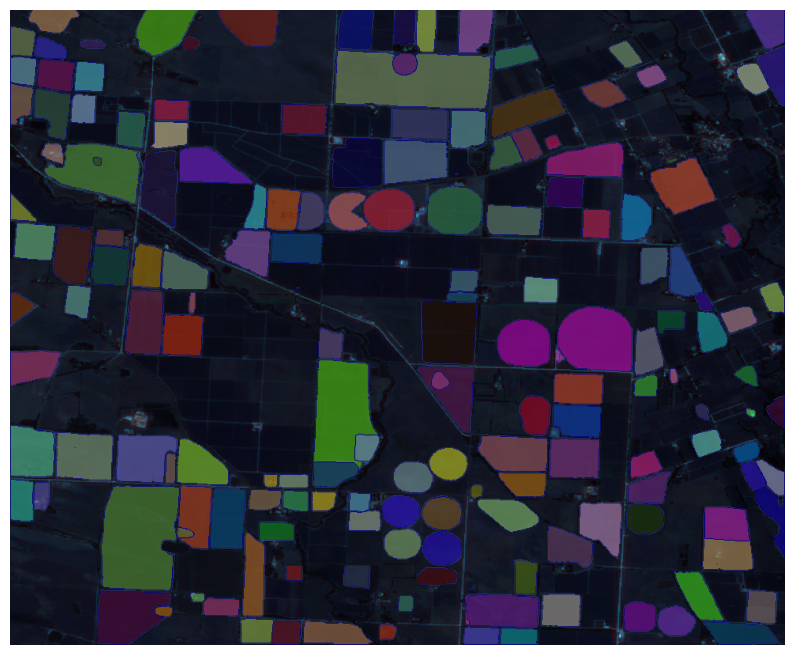

In [76]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

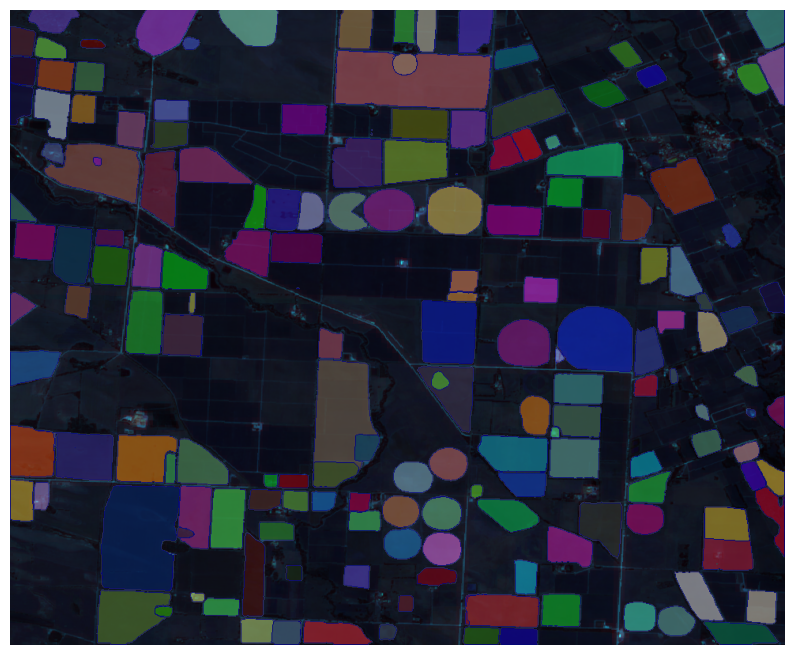

In [77]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(new_masks)
plt.axis('off')
plt.show() 